In [1]:
# imports
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# constants
value_threshold = 127
saturation_threshold = 50
saturation_weight = 8
snap_range = 32

In [2]:
def generateMockMask(mask_path):
    img = cv2.imread(mask_path)
    img_tmp = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img_tmp[:,:,2] > 250

In [3]:
# calculate average lightness of an hls image
def getAverageLightness(img_hsv):
    l_channel = img_hsv[:,:,2]
    return np.average(l_channel)

# take an rgb image and convert it to dark mode
def convertRegionToDark(img_rgb, mask):
    img_tmp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    for x in range(img_tmp.shape[0]):
        for y in range(img_tmp.shape[1]):
            if mask[x][y]:
                old_val = img_tmp[x][y][2]
                img_tmp[x][y][2] = 255 - math.pow(255 * 50000 * img_tmp[x][y][2], 1/4)
                # img_tmp[x][y][2] = (1000000 / math.pow((img_tmp[x][y][2] + 61.5), 2)) - 10
                # img_tmp[x][y][2] = (300000 / math.pow((img_tmp[x][y][2] + 34), 2)) - 4

                # if saturation is abolve a certain level, retain the color
                if img_tmp[x][y][1] > saturation_threshold:
                    img_tmp[x][y][2] = (img_tmp[x][y][2] + (old_val * saturation_weight)) / (2 + saturation_weight)

    return cv2.cvtColor(img_tmp, cv2.COLOR_HSV2RGB)

# take a generally dark image and go more extreme
def convertRegionToExtremeDark(img_rgb, mask):
    img_tmp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    for x in range(img_tmp.shape[0]):
        for y in range(img_tmp.shape[1]):
            if mask[x][y]:

                # if saturation low, snap the colors to white or black
                if img_tmp[x][y][1] < saturation_threshold:
                    img_tmp[x][y][2] = 255 / (1 + (math.pow(math.e, (40 - img_tmp[x][y][2]) / 8)))
                    # if img_tmp[x][y][2] < snap_range:
                    #     img_tmp[x][y][2] = 0
                    # if img_tmp[x][y][2] > 255 - snap_range:
                    #     img_tmp[x][y][2] = 255

    return cv2.cvtColor(img_tmp, cv2.COLOR_HSV2RGB)

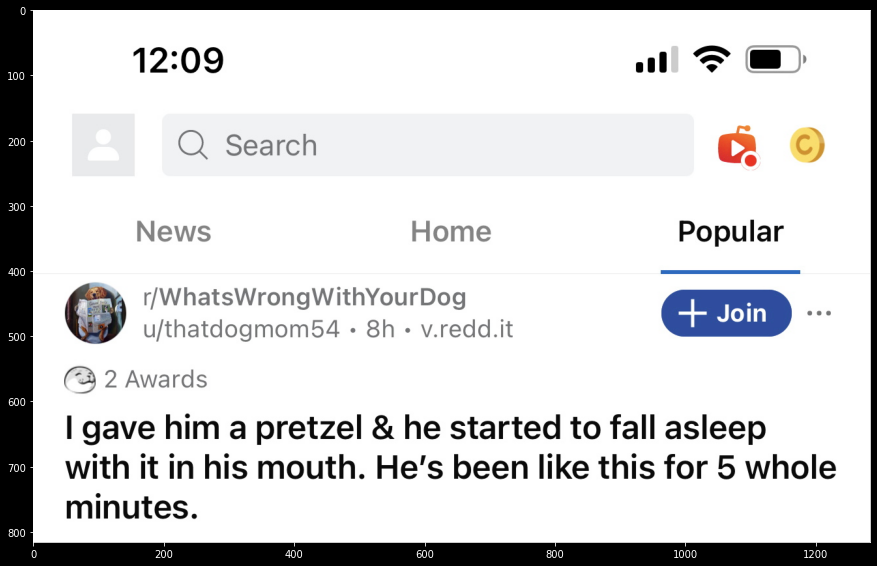

In [4]:
path = './screens/seg02_reddit-header.jpg'
img = cv2.imread(path)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.figure(figsize = (15, 15))
img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
plt.imshow(img_rgb)

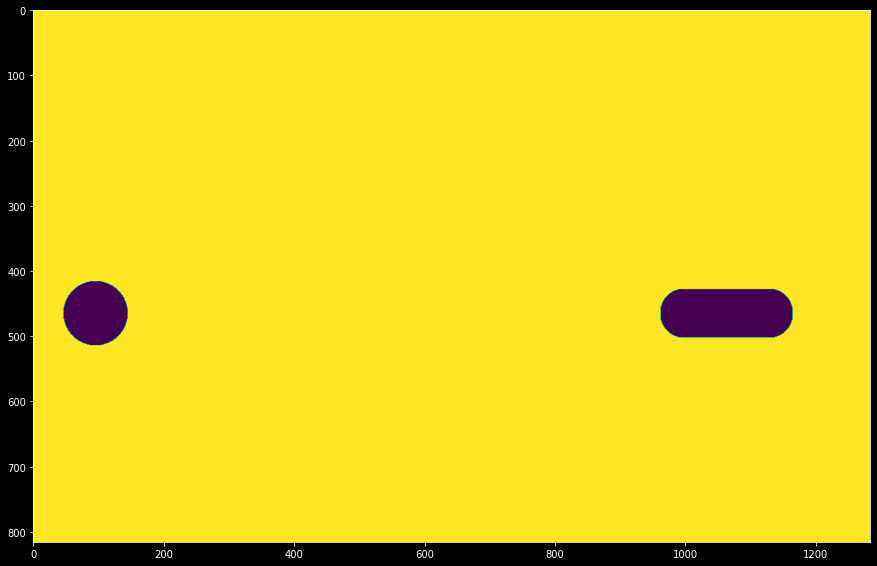

In [8]:
mask = generateMockMask('./screens/mask02_reddit-header.jpg')
plt.figure(figsize = (15, 15))
plt.imshow(mask)

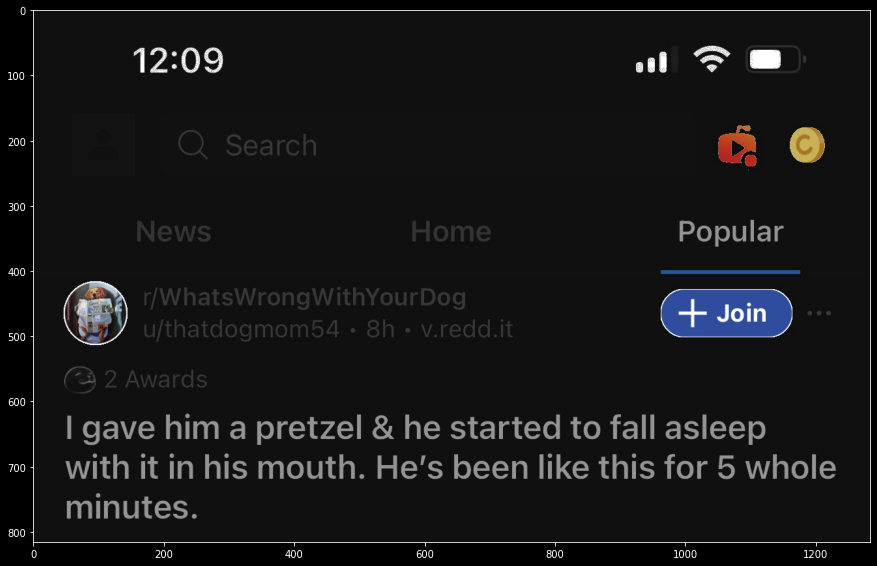

In [6]:
plt.figure(figsize = (15, 15))
img_dark = convertRegionToDark(img_rgb, mask)
plt.imshow(img_dark)

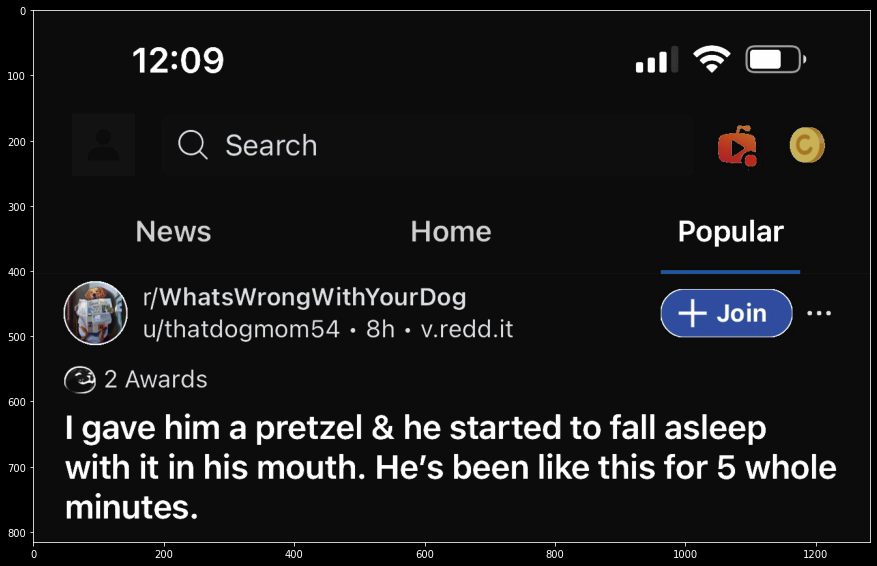

In [7]:
plt.figure(figsize = (15, 15))
img_exdark = convertRegionToExtremeDark(img_dark, mask)
plt.imshow(img_exdark)
